# 1. 패키지 임포트 및 설정

In [3]:
# 기타
import os

# 전처리 관련 패키지
import numpy as np
import pandas as pd
import pandas_profiling
import missingno as msno

# 시각화 패키지
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

if os.name == 'nt':
    mpl.rc('font', family = 'binggrae')
elif os.name == 'posix':
    mpl.rc('font', family = 'AppleGothic')
else:
    print('check your os')

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

# mpl.rc('font', family='binggrae')
mpl.rc('axes', unicode_minus=True)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 10000

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 2. 데이터 로드 및 전처리
- 테이블 변수명
    - df_oxi : Oxidation csv table
    - df_soft : Photo softback csv table
    - df_litho : Photo lithography csv table
    - df_etch : Etching csv table
    - df_imp : Ion implantation csv table
    - df_ins : Inspection csv table
    

> 각 테이블의 이상치나 결측치는 NaN으로 처리하고 최종 병합 후 drop

## 2.0 이상치 제거 함수 정의
- 모든 데이터 테이블에 적용한다

In [25]:
# 사분위수를 이용해서 이상치를 제거
# 제거 함수 정의
def remove_outlier(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    # print(q1, q3, lower_bound, upper_bound)
    
    mask = np.where((data<=upper_bound) & (data>=lower_bound), data, np.NaN)
    return mask

- **np.percentile() ?**

```python
np.percentile()

#주요인자
a : array_like
    Input array or object that can be converted to an array.
q : array_like of float
    Percentile or sequence of percentiles to compute, which must be between
    0 and 100 inclusive.
```

In [5]:
# 데이터 path
path = '../data/project1/'

## 2.1 Oxidation Data

In [6]:
# 산화 공정 데이터 테이블 Read
df_oxi = pd.read_csv(path+'Oxid.csv')
df_oxi.head(3)

Ox_Chamber    process type    Temp_OXid Vapor    ppm  Pressure  Oxid_time  \
0           1  Oxidation  dry  1138.979159    O2  32.80     0.200         62   
1           1  Oxidation  dry  1218.184551    O2  31.86     0.194        137   
2           1  Oxidation  dry  1062.467808    O2  39.51     0.217        128   

   thickness    No_Die  Lot_Num  Wafer_Num               Datetime  
0    699.443  NOLSM111        1          1  17-02-2019 PM 9:04:30  
1    696.792  NOLSM212        1          2  17-02-2019 PM 9:04:30  
2    705.471  NOLSM313        1          3  17-02-2019 PM 9:04:30

### 결측치 파악 

<Figure size 576x360 with 0 Axes>

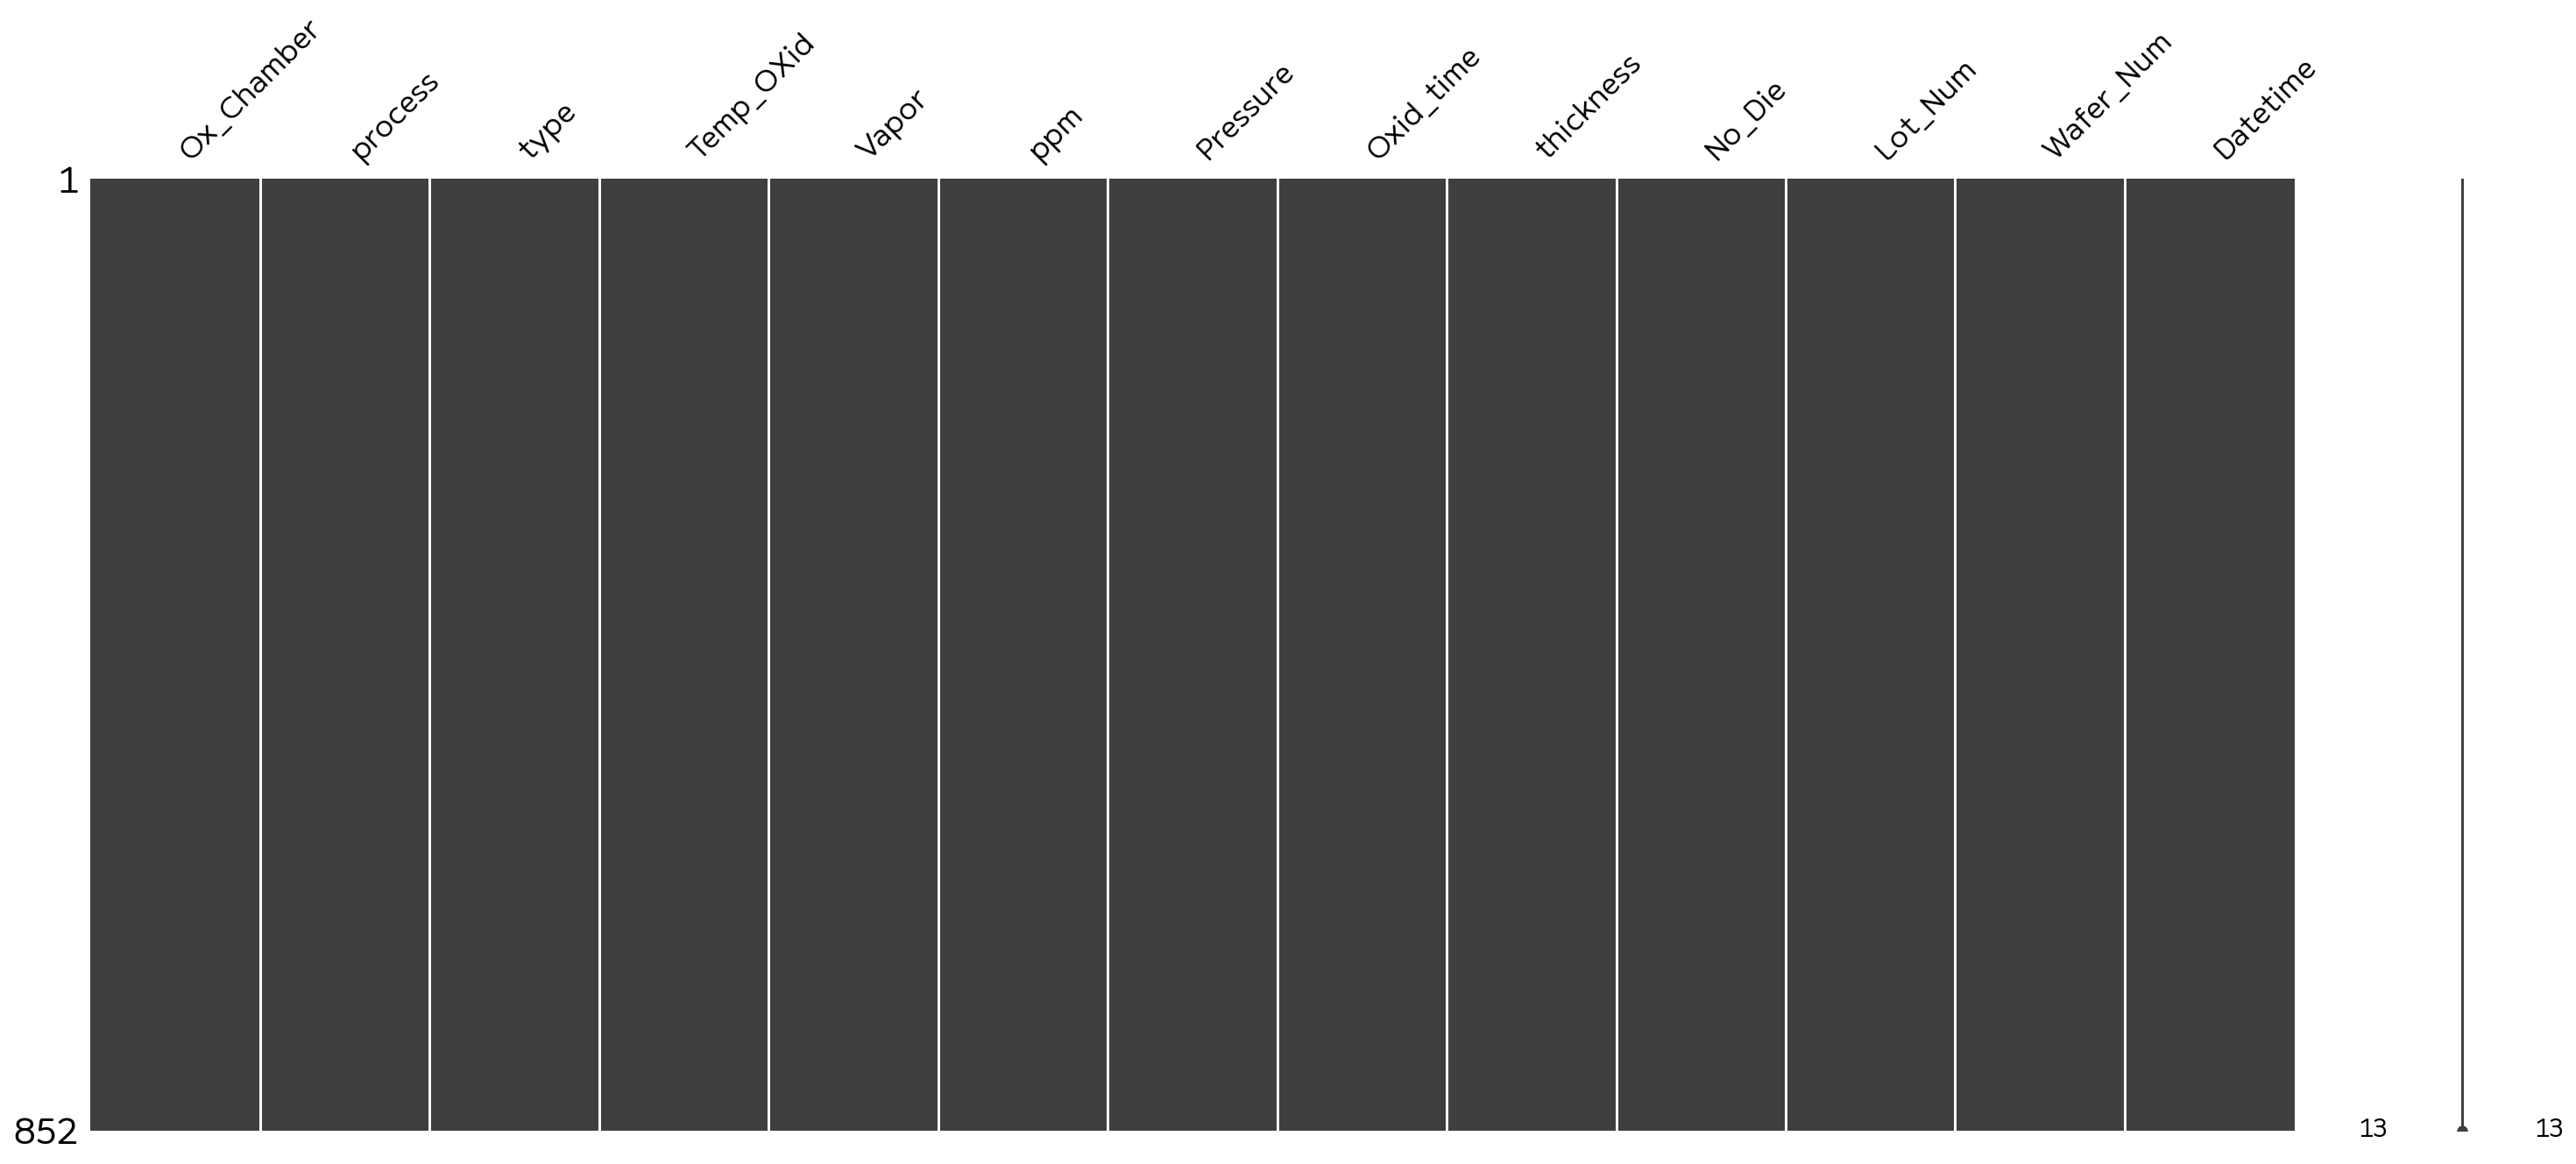

In [8]:
plt.figure(figsize=(8,5))
msno.matrix(df_oxi)
plt.show()
# 결측치는 없다.

### 이상치 파악 및 제거

In [10]:
# 컬럼 확인
print(np.array(df_oxi.columns))

['Ox_Chamber' 'process' 'type' 'Temp_OXid' 'Vapor' 'ppm' 'Pressure'
 'Oxid_time' 'thickness' 'No_Die' 'Lot_Num' 'Wafer_Num' 'Datetime']


In [11]:
df_oxi.describe()
# 연속형 변수는 Ox_Chamber, Temp_OXid, ppm, Pressure, Oxid_time, thickness, Lot_Num, Wafer_Num

Ox_Chamber    Temp_OXid         ppm    Pressure   Oxid_time  \
count   852.00000   852.000000  852.000000  852.000000  852.000000   
mean      2.00000  1064.415784   33.202242    0.211374  123.201878   
std       0.81265   149.550147    8.494070    0.009067   76.285130   
min       1.00000   862.011276   21.070000    0.180000   -6.000000   
25%       1.00000   874.756813   22.450000    0.205000   52.000000   
50%       2.00000  1069.240209   33.420000    0.213000  116.000000   
75%       3.00000  1189.172249   40.452500    0.217000  217.000000   
max       3.00000  1339.476675   49.910000    0.229000  291.000000   

        thickness     Lot_Num   Wafer_Num  
count  852.000000  852.000000  852.000000  
mean   710.926810   16.281690   13.894366  
std      8.082856    9.116841    7.785951  
min    681.435000    1.000000    1.000000  
25%    706.313000    8.000000    7.000000  
50%    711.590500   16.000000   14.000000  
75%    715.595000   24.000000   21.000000  
max    737.402000   32.000000   27.000000

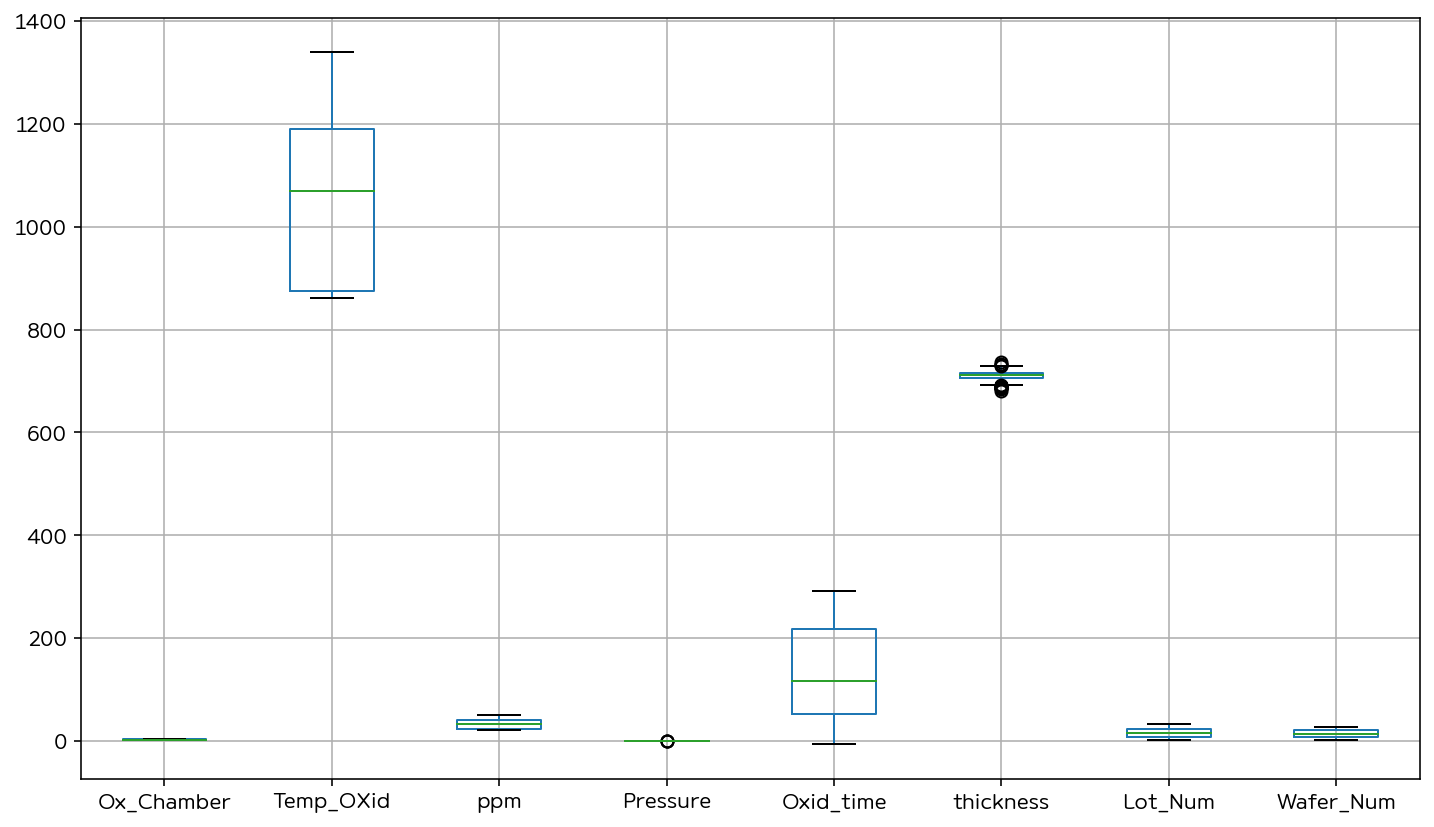

In [12]:
df_oxi.boxplot(figsize=(12,7))
plt.show()

In [26]:
# 아웃라이어 제거
continuous_ls = ['Ox_Chamber', 'Temp_OXid', 'ppm', 'Pressure', 'Oxid_time', 'thickness', 'Lot_Num', 'Wafer_Num']
for val in continuous_ls:
    df_oxi[val] = df_oxi[val].apply(remove_outlier)

In [28]:
# 시간이 0이하를 제거
df_oxi['Oxid_time'] = np.where(df_oxi['Oxid_time'] <= 0 , np.nan, df_oxi['Oxid_time'])

# thickness가 이론적으로 700nm 이상이 되야 다음 공정이 원할히 진행될 수 있음.
# 700이상은 두고 미만은 제거할 예정
# 700이상의 데이터를 Reinforcement 컬럼을 추가해 True, False 값 추가
df_oxi['Reinforcement'] = np.where(df_oxi['thickness'] >= 700., True, False)
df_oxi.head(3)

Ox_Chamber    process type    Temp_OXid Vapor    ppm  Pressure  Oxid_time  \
0         1.0  Oxidation  dry  1138.979159    O2  32.80     0.200       62.0   
1         1.0  Oxidation  dry  1218.184551    O2  31.86     0.194      137.0   
2         1.0  Oxidation  dry  1062.467808    O2  39.51     0.217      128.0   

   thickness    No_Die  Lot_Num  Wafer_Num               Datetime  \
0    699.443  NOLSM111      1.0        1.0  17-02-2019 PM 9:04:30   
1    696.792  NOLSM212      1.0        2.0  17-02-2019 PM 9:04:30   
2    705.471  NOLSM313      1.0        3.0  17-02-2019 PM 9:04:30   

   Reinforcement  
0          False  
1          False  
2           True

In [30]:
# 정상 wafer와 700nm 이하 wafer에 대해, oxidation 연속형 변수에 대해서 평균값 확인
df_oxi.pivot_table(index='Reinforcement', values=['Oxid_time', 'Pressure', 'Temp_OXid', 'ppm'])

# 차후 통계적 가설 검증을 통해, 산화막 증착 시간이 박막 두께에 대해 유의미한 차이가 있는지 확인

Oxid_time  Pressure    Temp_OXid        ppm
Reinforcement                                              
False          111.448718  0.206524  1082.455629  34.090732
True           125.555411  0.211891  1062.494658  33.107623

## 2.2 Softbake Data

In [31]:
df_soft = pd.read_csv(path+'Photo_Softbake.csv')
df_soft.drop('Unnamed: 0', axis=1, inplace=True)
df_soft.head()

photo_soft_Chamber process 2  resist_target  N2_HMDS  pressure_HMDS  \
0                   1     Photo       1.211940   13.891         15.025   
1                   1     Photo       0.887720   14.722         15.059   
2                   1     Photo       1.113156   19.205         14.964   
3                   2     Photo       0.882195   16.368         14.944   
4                   2     Photo       0.834001   13.926         14.933   

   temp_HMDS  temp_HMDS_bake  time_HMDS_bake    spin1     spin2     spin3  \
0     20.000         198.792          90.001  504.589  4082.622  5184.620   
1     19.995         198.747          89.998  492.196  3960.739  5065.197   
2     19.997         202.139          90.000  499.886  3981.691  4873.417   
3     19.998         199.649          90.001  505.249  3922.191  5131.972   
4     20.002         204.544          90.001  501.089  4124.099  5108.355   

   photoresist_bake  temp_softbake  time_softbake    No_Die  Lot_Num  \
0             5.044         90.894         30.009  NOLSM111        1   
1             5.058         92.334         29.997  NOLSM212        1   
2             5.151         91.868         30.005  NOLSM313        1   
3             5.069         91.881         29.997  NOLSM414        1   
4             5.055         91.212         30.001  NOLSM515        1   

   Wafer_Num               Datetime  
0          1  17-02-2019 PM 9:04:30  
1          2  17-02-2019 PM 9:04:30  
2          3  17-02-2019 PM 9:04:30  
3          4  17-02-2019 PM 9:04:30  
4          5  17-02-2019 PM 9:04:30

### 이상치 제거

In [32]:
# 연속형 변수의 컬럼명만 추출
continuous_ls = list(df_soft.select_dtypes(exclude = 'object').columns)
for val in continuous_ls :
    df_soft[val] = df_soft[val].apply(remove_outlier)

## 2.3 Lithography Data

In [34]:
df_litho = pd.read_csv(path+'Photo_lithography.csv')
df_litho.head(3)

lithography_Chamber  Line_CD    Lamp UV_type  Wavelength  Resolution  \
0                    1   30.959  Hg-Arc       H         405     516.657   
1                    2   29.653  Hg-Arc       H         405     501.894   
2                    3   28.063  Hg-Arc       I         365     506.750   

   Energy_Exposure    No_Die  Lot_Num  Wafer_Num               Datetime  
0          109.769  NOLSM111        1          1  17-02-2019 PM 9:04:30  
1          107.102  NOLSM212        1          2  17-02-2019 PM 9:04:30  
2          110.471  NOLSM313        1          3  17-02-2019 PM 9:04:30

### 이상치 제거

In [35]:
continuous_ls = list(df_litho.select_dtypes(exclude = 'object').columns)
for val in continuous_ls:
    df_litho[val] = df_litho[val].apply(remove_outlier)

### Line Critical Dimension으로 나누기
- 리소그래피의 결과로 그려진 웨이퍼의 line pattern 간의 거리로 적정값이 25~55nm 사이다.

In [37]:
df_litho['Range_check'] = np.where((df_litho['Line_CD'] >=25) & (df_litho['Line_CD'] <= 55), True, False)
df_litho.head(3)

lithography_Chamber  Line_CD    Lamp UV_type  Wavelength  Resolution  \
0                  1.0   30.959  Hg-Arc       H       405.0     516.657   
1                  2.0   29.653  Hg-Arc       H       405.0     501.894   
2                  3.0   28.063  Hg-Arc       I       365.0     506.750   

   Energy_Exposure    No_Die  Lot_Num  Wafer_Num               Datetime  \
0          109.769  NOLSM111      1.0        1.0  17-02-2019 PM 9:04:30   
1          107.102  NOLSM212      1.0        2.0  17-02-2019 PM 9:04:30   
2          110.471  NOLSM313      1.0        3.0  17-02-2019 PM 9:04:30   

   Range_check  
0         True  
1         True  
2         True

In [41]:
pd.crosstab(index=df_litho['Range_check'], columns=df_litho['UV_type'])
# H Type beam에서 False값이 높다.
# 추후 통계적 가설검정을 통해 해당 공정에 대한 out of range 확인 예정

UV_type        G    H    I
Range_check               
False         45   94   48
True         267  192  206

## 2.4 Etching Data

In [54]:
df_etch = pd.read_csv(path+'Etching.csv')
df_etch.drop('Unnamed: 0', axis=1, inplace=True)
df_etch.head(3)

Etching_Chamber Process 3  Temp_Etching  Source_Power  Selectivity  \
0                3   Etching        70.878        50.851        1.047   
1                2   Etching        69.561        52.283        1.051   
2                1   Etching        70.968        51.610        1.017   

     No_Die  Lot_Num  Wafer_Num               Datetime  Thin Film 4  \
0  NOLSM111        1          1  17-02-2019 PM 9:04:30        251.0   
1  NOLSM212        1          2  17-02-2019 PM 9:04:30        317.0   
2  NOLSM313        1          3  17-02-2019 PM 9:04:30        411.0   

   Thin Film 3  Thin Film 2  Thin Film 1  
0       267.06       303.82       361.38  
1       332.74       369.31       426.11  
2       424.21       460.65       517.80

In [55]:
print(df_etch.shape)
df_etch.describe()

(852, 13)


Etching_Chamber  Temp_Etching  Source_Power  Selectivity     Lot_Num  \
count       852.000000    852.000000    852.000000   852.000000  852.000000   
mean          1.967136     71.147822     51.227459     1.032140   16.281690   
std           0.830584      0.824158      0.634215     0.016238    9.116841   
min           1.000000     68.150000     49.342000     0.984000    1.000000   
25%           1.000000     70.709750     50.794500     1.022000    8.000000   
50%           2.000000     71.220500     51.247000     1.033500   16.000000   
75%           3.000000     71.656500     51.698250     1.043000   24.000000   
max           3.000000     73.081000     53.272000     1.076000   32.000000   

        Wafer_Num  Thin Film 4  Thin Film 3  Thin Film 2  Thin Film 1  
count  852.000000   851.000000   851.000000   851.000000   851.000000  
mean    13.894366   296.633373   311.276439   347.799401   404.940012  
std      7.785951   125.378446   125.714630   125.774630   125.790535  
min      1.000000   -49.000000   -34.650000     2.000000    59.380000  
25%      7.000000   202.000000   216.525000   252.880000   310.185000  
50%     14.000000   281.000000   295.970000   332.480000   389.630000  
75%     21.000000   372.000000   386.675000   423.050000   480.355000  
max     27.000000   687.000000   700.240000   736.510000   793.500000

### 이상치제거

In [57]:
continuous_ls = list(df_etch.select_dtypes(exclude = 'object').columns)
for val in continuous_ls :
    df_etch[val] = df_etch[val].apply(remove_outlier)

### Etching 공정 데이터에서 Thin Film 값이 150nm 이하로 떨어지는 값을 제거
- Thin Film이 150nm 이상이 되어야 다음 공정이 가능하다고 한다.

In [45]:
for i in range(1,5):
    df_ethc[f'Thin Film {i}'] = np.where(df_ethc[f'Thin Film {i}']<150, np.NaN, df_ethc[f'Thin Film {i}'])

### Etching Rate
- 식각공정 중 표면에 material이 제거되는 속도
- 추후 etching rate가 품지에 영향을 얼마나 미치는지 확인할 예정

$$ ER = \frac{thin1 - thin4}{30} $$

In [47]:
df_ethc['ER'] = (df_ethc['Thin Film 1'].round(3) - df_ethc['Thin Film 4'].round(3)) / 30
df_ethc.head(3)

Etching_Chamber Process 3  Temp_Etching  Source_Power  Selectivity  \
0                3   Etching        70.878        50.851        1.047   
1                2   Etching        69.561        52.283        1.051   
2                1   Etching        70.968        51.610        1.017   

     No_Die  Lot_Num  Wafer_Num               Datetime  Thin Film 4  \
0  NOLSM111        1          1  17-02-2019 PM 9:04:30        251.0   
1  NOLSM212        1          2  17-02-2019 PM 9:04:30        317.0   
2  NOLSM313        1          3  17-02-2019 PM 9:04:30        411.0   

   Thin Film 3  Thin Film 2  Thin Film 1        ER  
0       267.06       303.82       361.38  3.679333  
1       332.74       369.31       426.11  3.637000  
2       424.21       460.65       517.80  3.560000

## 2.5 Implantation

In [48]:
df_imp = pd.read_csv(path+'Implant.csv')
df_imp.head(3)

Chamber_Num      process4       Flux60s       Flux90s      Flux160s  \
0            3  Implantation  9.997373e+15  1.346079e+17  3.468281e+17   
1            2  Implantation  9.705928e+15  1.389326e+17  3.838008e+17   
2            1  Implantation  1.761358e+16  8.782248e+16  6.014497e+17   

       Flux480s      Flux840s  input_Energy  Current  Temp_implantation  \
0  3.002593e+17  6.000007e+17     31574.410     0.01            102.847   
1  3.017903e+17  6.000012e+17     31580.213     0.01            104.323   
2  2.994231e+17  6.000002e+17     32162.414     0.01            100.605   

   Furance_Temp  RTA_Temp    No_Die  Lot_Num  Wafer_Num               Datetime  
0         885.0       154  NOLSM111        1          1  17-02-2019 ?? 9:04:30  
1         919.0       154  NOLSM212        1          2  17-02-2019 ?? 9:04:30  
2         916.0       155  NOLSM313        1          3  17-02-2019 ?? 9:04:30

In [49]:
df_imp.describe()
# 음수값이 나오는 컬럼은 Flux90s, Flux160s임

Chamber_Num       Flux60s       Flux90s      Flux160s      Flux480s  \
count   852.000000  8.510000e+02  8.510000e+02  8.510000e+02  8.520000e+02   
mean      1.967136  1.186913e+16  7.982876e+16  4.483541e+17  3.002006e+17   
std       0.830584  4.603012e+15  5.478891e+16  3.322530e+17  1.145362e+15   
min       1.000000  1.967326e+15 -4.117940e+16 -6.930960e+16  2.963401e+17   
25%       1.000000  8.590656e+15  3.081442e+16  1.319423e+17  2.994309e+17   
50%       2.000000  1.177267e+16  8.132774e+16  4.571101e+17  3.001862e+17   
75%       3.000000  1.516101e+16  1.209841e+17  6.816896e+17  3.009426e+17   
max       3.000000  2.403938e+16  2.720974e+17  1.401808e+18  3.036145e+17   

           Flux840s  input_Energy       Current  Temp_implantation  \
count  8.520000e+02    852.000000  8.520000e+02         852.000000   
mean   5.999997e+17  32007.862815  1.000000e-02         103.161261   
std    1.080690e+12    588.322496  1.614240e-16           1.654830   
min    5.999965e+17  29604.262000  1.000000e-02          97.744000   
25%    5.999990e+17  31640.161000  1.000000e-02         102.063500   
50%    5.999997e+17  32200.488500  1.000000e-02         103.295500   
75%    6.000004e+17  32420.668750  1.000000e-02         104.322000   
max    6.000025e+17  33675.551000  1.000000e-02         107.376000   

       Furance_Temp    RTA_Temp     Lot_Num   Wafer_Num  
count    851.000000  852.000000  852.000000  852.000000  
mean     901.128085  154.696009   16.281690   13.894366  
std       18.487803    2.420114    9.116841    7.785951  
min      854.000000  148.000000    1.000000    1.000000  
25%      890.000000  153.000000    8.000000    7.000000  
50%      904.000000  155.000000   16.000000   14.000000  
75%      915.000000  156.000000   24.000000   21.000000  
max      944.000000  162.000000   32.000000   27.000000

### 이상치 제거

In [50]:
continuous_ls = list(df_imp.select_dtypes(exclude = 'object').columns)
for val in continuous_ls :
    df_imp[val] = df_imp[val].apply(remove_outlier)

### 음수 값으로 측정되는 이상치 제거

In [53]:
print(np.where(df_imp.select_dtypes(exclude = 'object')['Flux60s'].isnull())[0])
df_imp[df_imp['Flux60s'].isnull()]
# 702번 인덱스의 값엔 NaN이 존재.

[702]


Chamber_Num      process4  Flux60s  Flux90s  Flux160s      Flux480s  \
702          2.0  Implantation      NaN      NaN       NaN  3.002952e+17   

         Flux840s  input_Energy  Current  Temp_implantation  Furance_Temp  \
702  5.999998e+17     32437.886     0.01            104.475           NaN   

     RTA_Temp       No_Die  Lot_Num  Wafer_Num               Datetime  
702     157.0  NOLSM703271     27.0        1.0  23-02-2019 ?? 9:04:30

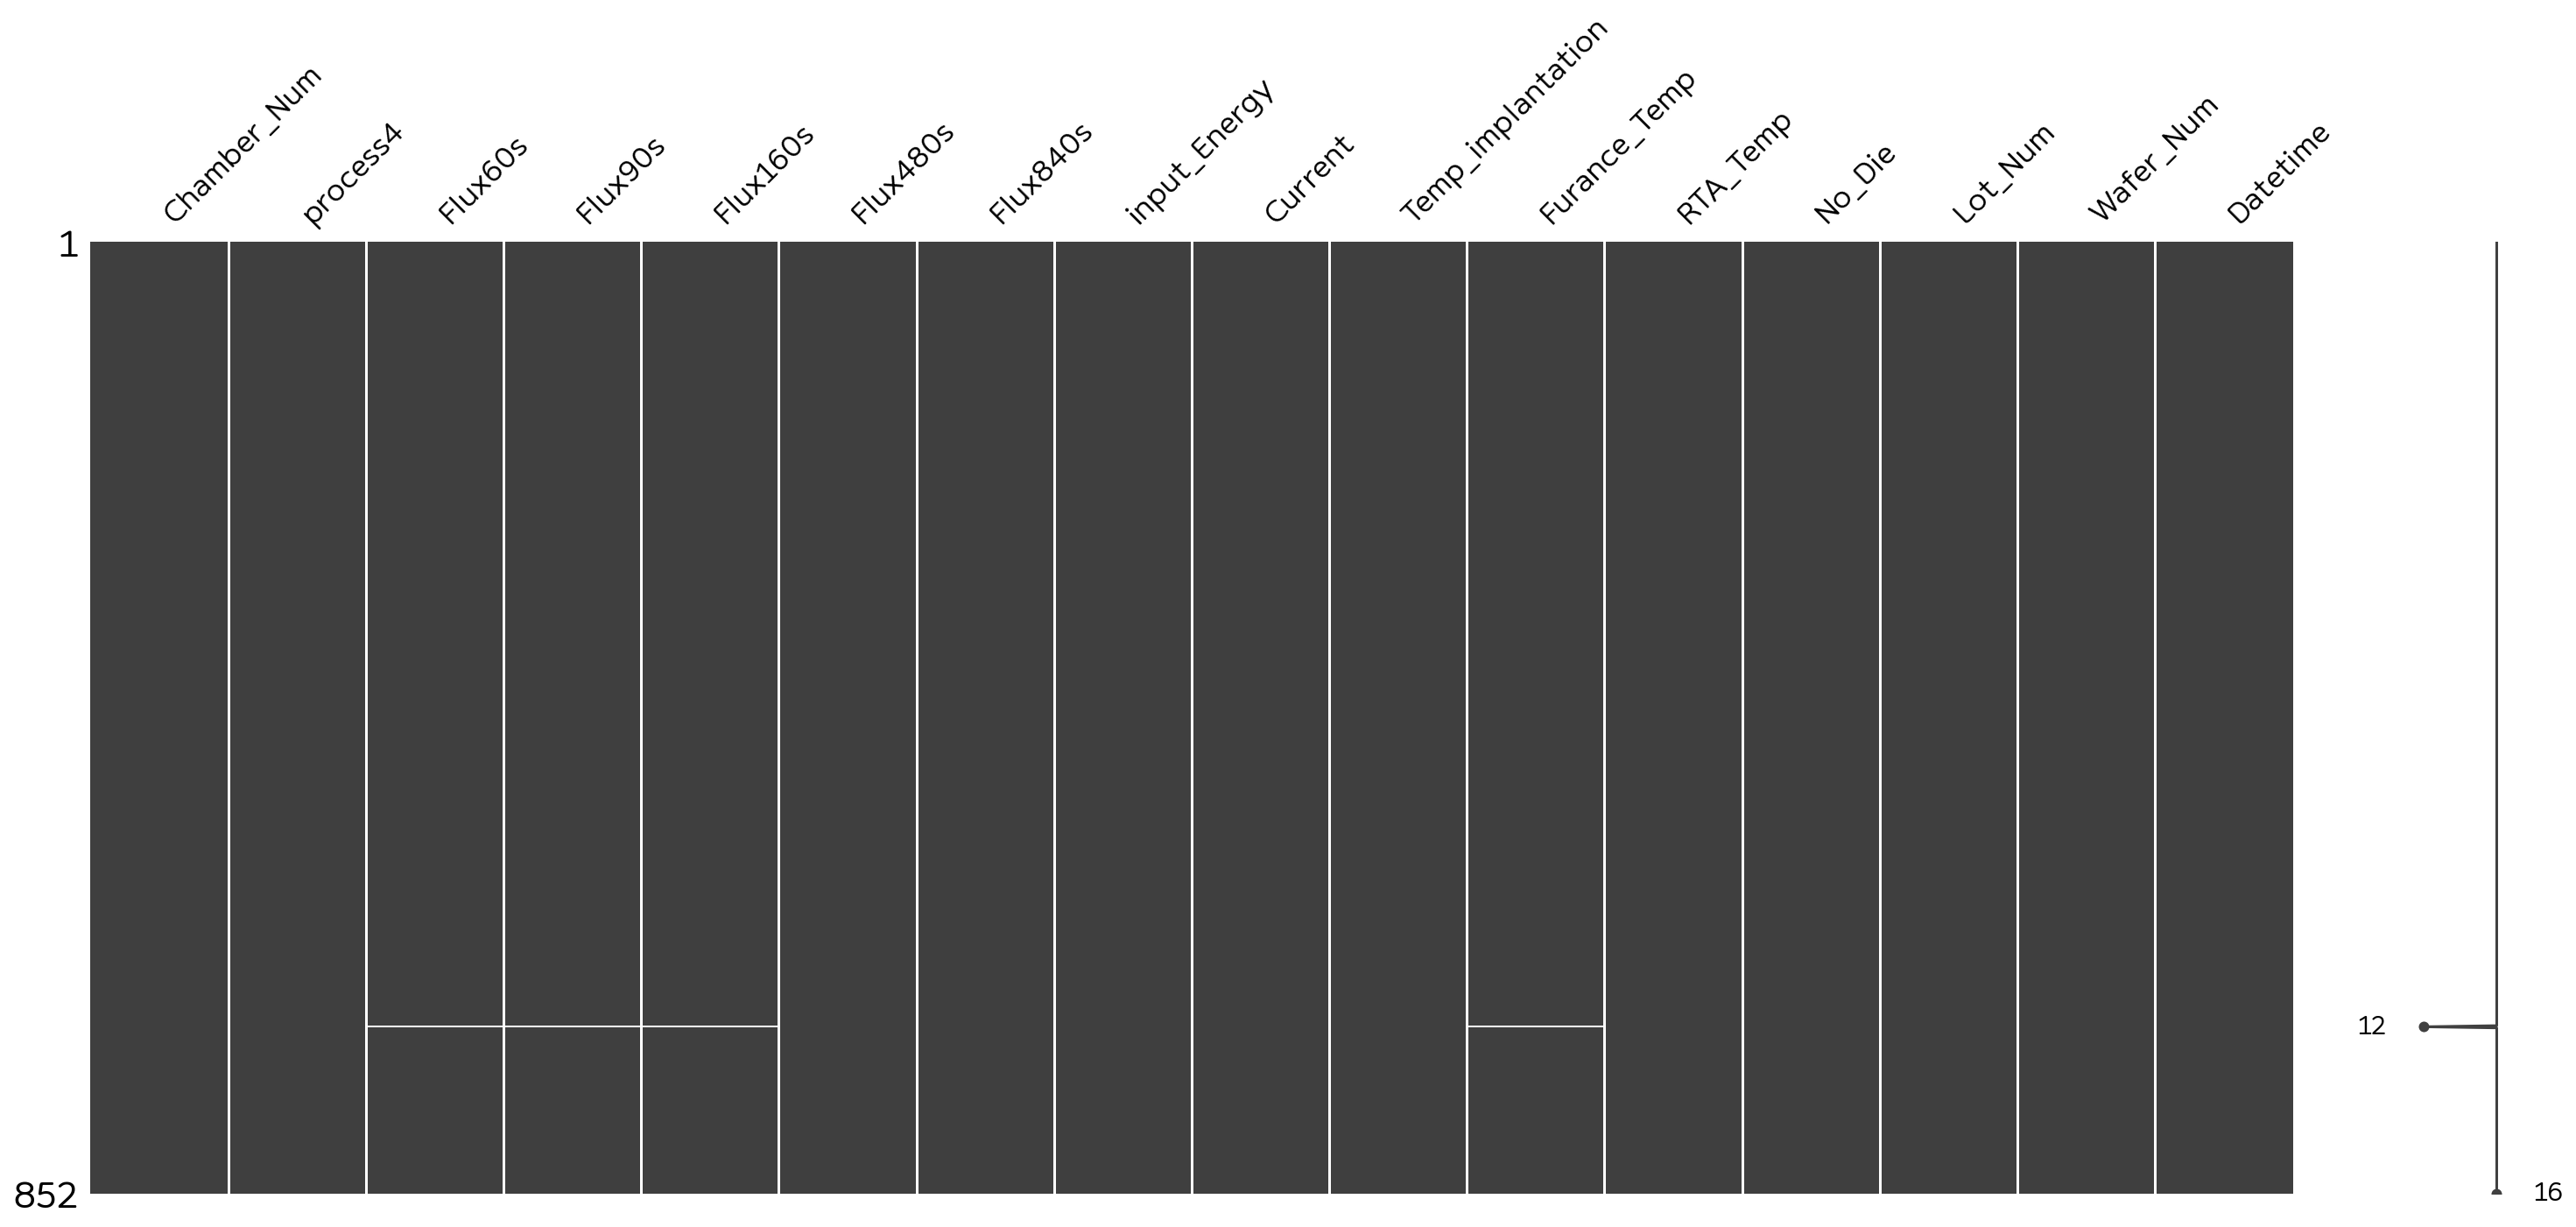

In [36]:
msno.matrix(df_imp)
plt.show()

In [37]:
df_imp['Flux90s'] = np.where(df_imp['Flux90s']<0, np.NaN, df_imp['Flux90s'])
df_imp['Flux160s'] = np.where(df_imp['Flux160s']<0, np.NaN, df_imp['Flux160s'])

## 2.6 Inspection
- 품질 검사에서 발생한 Error 처리
- Error 유무로 새로운 카테고리 값 생성

In [59]:
df_ins = pd.read_csv(path+'Inspect.csv')
df_ins.head()

Target    No_Die  Lot_Num  Wafer_Num    Datetime Error_message  \
0      96  NOLSM111        1          1  02-18-2018          none   
1     102  NOLSM212        1          2  02-18-2018          none   
2      95  NOLSM313        1          3  02-18-2018          none   
3     117  NOLSM414        1          4  02-18-2018          none   
4     143  NOLSM515        1          5  02-18-2018          none   

                                           Wafer_map  
0  [[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...  
1  [[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...  
2  [[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...  
3  [[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...  
4  [[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...

### 에러 메시지가 있으면 1, 없으면 0으로 이산형 변수의 새 컬럼 생성

In [60]:
df_ins['target_binom'] = np.where(df_ins['Error_message']=='none', 0.0, 1.0)
df_ins.head()

Target    No_Die  Lot_Num  Wafer_Num    Datetime Error_message  \
0      96  NOLSM111        1          1  02-18-2018          none   
1     102  NOLSM212        1          2  02-18-2018          none   
2      95  NOLSM313        1          3  02-18-2018          none   
3     117  NOLSM414        1          4  02-18-2018          none   
4     143  NOLSM515        1          5  02-18-2018          none   

                                           Wafer_map  target_binom  
0  [[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...           0.0  
1  [[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...           0.0  
2  [[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...           0.0  
3  [[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...           0.0  
4  [[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...           0.0

In [61]:
df_ins['target_binom'].value_counts()

0.0    786
1.0     66
Name: target_binom, dtype: int64

# 3. 데이터 병합

### 아래의 각 테이블을 Key : No_Die로 left join
- df_ethc
- df_imp
- df_ins
- df_litho
- df_soft
- df_oxi

In [63]:
df1 = pd.merge(df_ethc, df_imp, on='No_Die', how='left')
df1 = pd.merge(df1, df_ins, on='No_Die', how='left')
df1 = pd.merge(df1, df_litho, on='No_Die', how='left')
df1 = pd.merge(df1, df_oxi, on='No_Die', how='left')
df1 = pd.merge(df1, df_soft, on='No_Die', how='left')
df1.head(3)

Etching_Chamber Process 3  Temp_Etching  Source_Power  Selectivity  \
0                3   Etching        70.878        50.851        1.047   
1                2   Etching        69.561        52.283        1.051   
2                1   Etching        70.968        51.610        1.017   

     No_Die  Lot_Num_x  Wafer_Num_x             Datetime_x  Thin Film 4  \
0  NOLSM111          1            1  17-02-2019 PM 9:04:30        251.0   
1  NOLSM212          1            2  17-02-2019 PM 9:04:30        317.0   
2  NOLSM313          1            3  17-02-2019 PM 9:04:30        411.0   

   Thin Film 3  Thin Film 2  Thin Film 1        ER  Chamber_Num      process4  \
0       267.06       303.82       361.38  3.679333          3.0  Implantation   
1       332.74       369.31       426.11  3.637000          2.0  Implantation   
2       424.21       460.65       517.80  3.560000          1.0  Implantation   

        Flux60s       Flux90s      Flux160s      Flux480s      Flux840s  \
0  9.997373e+15  1.346079e+17  3.468281e+17  3.002593e+17  6.000007e+17   
1  9.705928e+15  1.389326e+17  3.838008e+17  3.017903e+17  6.000012e+17   
2  1.761358e+16  8.782248e+16  6.014497e+17  2.994231e+17  6.000002e+17   

   input_Energy  Current  Temp_implantation  Furance_Temp  RTA_Temp  \
0     31574.410     0.01            102.847         885.0     154.0   
1     31580.213     0.01            104.323         919.0     154.0   
2     32162.414     0.01            100.605         916.0     155.0   

   Lot_Num_y  Wafer_Num_y             Datetime_y  Target  Lot_Num_x  \
0        1.0          1.0  17-02-2019 ?? 9:04:30      96          1   
1        1.0          2.0  17-02-2019 ?? 9:04:30     102          1   
2        1.0          3.0  17-02-2019 ?? 9:04:30      95          1   

   Wafer_Num_x  Datetime_x Error_message  \
0            1  02-18-2018          none   
1            2  02-18-2018          none   
2            3  02-18-2018          none   

                                           Wafer_map  target_binom  \
0  [[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...           0.0   
1  [[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...           0.0   
2  [[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...           0.0   

   lithography_Chamber  Line_CD    Lamp UV_type  Wavelength  Resolution  \
0                  1.0   30.959  Hg-Arc       H       405.0     516.657   
1                  2.0   29.653  Hg-Arc       H       405.0     501.894   
2                  3.0   28.063  Hg-Arc       I       365.0     506.750   

   Energy_Exposure  Lot_Num_y  Wafer_Num_y             Datetime_y  \
0          109.769        1.0          1.0  17-02-2019 PM 9:04:30   
1          107.102        1.0          2.0  17-02-2019 PM 9:04:30   
2          110.471        1.0          3.0  17-02-2019 PM 9:04:30   

   Range_check  Ox_Chamber    process type    Temp_OXid Vapor    ppm  \
0         True         1.0  Oxidation  dry  1138.979159    O2  32.80   
1         True         1.0  Oxidation  dry  1218.184551    O2  31.86   
2         True         1.0  Oxidation  dry  1062.467808    O2  39.51   

   Pressure  Oxid_time  thickness  Lot_Num_x  Wafer_Num_x  \
0     0.200       62.0    699.443        1.0          1.0   
1     0.194      137.0    696.792        1.0          2.0   
2     0.217      128.0    705.471        1.0          3.0   

              Datetime_x  Reinforcement  photo_soft_Chamber process 2  \
0  17-02-2019 PM 9:04:30          False                 1.0     Photo   
1  17-02-2019 PM 9:04:30          False                 1.0     Photo   
2  17-02-2019 PM 9:04:30           True                 1.0     Photo   

   resist_target  N2_HMDS  pressure_HMDS  temp_HMDS  temp_HMDS_bake  \
0       1.211940   13.891         15.025     20.000         198.792   
1       0.887720   14.722         15.059     19.995         198.747   
2       1.113156   19.205         14.964     19.997         202.139   

   time_HMDS_bake    spin1     spin2     spin3  photoresist_bake 

In [64]:
print(df1.shape)

(852, 77)


### 병합된 데이터에서 null값 한번에 제거
- join한 데이터 테이블 : df1
- 결측치를 제거한 테이블 df2

In [66]:
df2 = df1.dropna()
df2.shape

(769, 77)

In [67]:
df2.isnull().sum()

Etching_Chamber        0
Process 3              0
Temp_Etching           0
Source_Power           0
Selectivity            0
No_Die                 0
Lot_Num_x              0
Wafer_Num_x            0
Datetime_x             0
Thin Film 4            0
Thin Film 3            0
Thin Film 2            0
Thin Film 1            0
ER                     0
Chamber_Num            0
process4               0
Flux60s                0
Flux90s                0
Flux160s               0
Flux480s               0
Flux840s               0
input_Energy           0
Current                0
Temp_implantation      0
Furance_Temp           0
RTA_Temp               0
Lot_Num_y              0
Wafer_Num_y            0
Datetime_y             0
Target                 0
Lot_Num_x              0
Wafer_Num_x            0
Datetime_x             0
Error_message          0
Wafer_map              0
target_binom           0
lithography_Chamber    0
Line_CD                0
Lamp                   0
UV_type                0


# 4. 병합 데이터 전처리

In [69]:
df2['Chamber_Route'] = 'route_'+df2['Ox_Chamber'].apply(str)+df2['photo_soft_Chamber'].apply(str)+df2['lithography_Chamber'].apply(str)+df2['Etching_Chamber'].apply(str)+df2['Chamber_Num'].apply(str)
df2

Etching_Chamber Process 3  Temp_Etching  Source_Power  Selectivity  \
0                  3   Etching        70.878        50.851        1.047   
1                  2   Etching        69.561        52.283        1.051   
2                  1   Etching        70.968        51.610        1.017   
3                  1   Etching        70.146        51.286        1.027   
4                  2   Etching        71.174        51.996        1.050   
5                  3   Etching        71.709        51.931        1.012   
6                  2   Etching        71.354        51.446        1.034   
7                  1   Etching        70.761        51.053        1.022   
8                  1   Etching        71.716        51.209        1.039   
9                  2   Etching        69.948        50.944        1.024   
10                 3   Etching        70.610        51.473        1.048   
11                 3   Etching        71.067        51.129        1.043   
12                 2   Etching        69.934        51.099        1.023   
13                 1   Etching        72.593        50.252        1.024   
14                 1   Etching        71.754        52.645        1.038   
15                 2   Etching        71.441        51.015        1.027   
16                 3   Etching        71.163        50.547        1.009   
17                 3   Etching        70.345        50.843        1.015   
18                 2   Etching        69.832        51.609        1.011   
19                 1   Etching        71.606        51.027        1.024   
20                 1   Etching        71.068        50.653        1.029   
21                 2   Etching        69.362        51.252        1.026   
22                 3   Etching        72.506        50.769        1.044   
23                 3   Etching        71.744        50.936        1.060   
24                 2   Etching        71.199        51.446        1.024   
25                 1   Etching        71.553        50.168        1.011   
26                 1   Etching        69.650        51.216        1.053   
27                 2   Etching        70.341        51.052        1.060   
28                 3   Etching        71.972        52.479        1.042   
29                 3   Etching        71.448        51.337        1.016   
31                 1   Etching        71.025        50.813        1.034   
32                 3   Etching        71.306        51.814        1.020   
33                 3   Etching        71.297        50.787        1.031   
34                 2   Etching        70.839        50.837        1.028   
35                 1   Etching        69.835        52.027        1.040   
37                 2   Etching        70.915        51.108        1.036   
38                 3   Etching        69.914        51.379        1.037   
39                 3   Etching        70.941        51.727        1.045   
40                 2   Etching        71.774        51.297        1.054   
41                 1   Etching        69.947        51.177        1.019   
42                 1   Etching        71.607        50.932        1.034   
43                 2   Etching        71.176        52.269        1.032   
44                 3   Etching        70.758        51.796        1.008   
45                 3   Etching        70.973        51.770        1.012   
46                 2   Etching        71.049        51.212        1.024   
47                 1   Etching        70.119        51.770        1.033   
48                 1   Etching        72.115        50.716        1.037   
49                 2   Etching        70.245        50.290        1.017   
50                 3   Etching        70.437        50.087        1.027   
51                 3   Etching        70.888        51.091        1.014   
52                 2   Etching        70.392        50.488        1.056   
53                 1   Etching        72.489        51.776        1.034   
54                 1   Etching

In [ ]:
a = 'kkkkkasdasdasd'
a/2

### 불필요한 공정변수 제거 후, 데이터 파일로 저장

In [48]:
df3 = df2.drop(columns=['Lot_Num_x', 'Wafer_Num_x', 'Datetime_x', 
                        'Lot_Num_y', 'Wafer_Num_y', 'Datetime_y', 'Lamp', 'Wafer_map', 'Current'])
print(df3.shape)

(759, 57)


In [49]:
df3.to_csv('preprocessing_data.csv')

In [50]:
df2.shape

(759, 78)

# 5. 데이터 시각화 및 가설검증

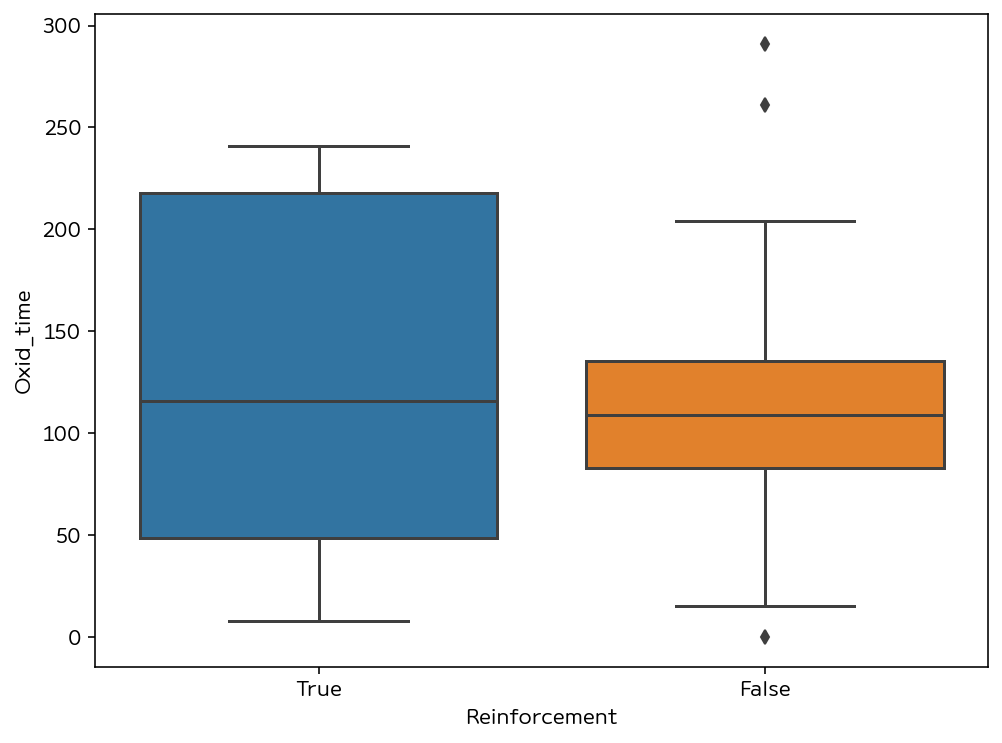

In [51]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df3['Reinforcement'], y=df3['Oxid_time'], order=[True, False])
plt.show()

In [52]:
from scipy import stats

<AxesSubplot:xlabel='Oxid_time', ylabel='Count'>

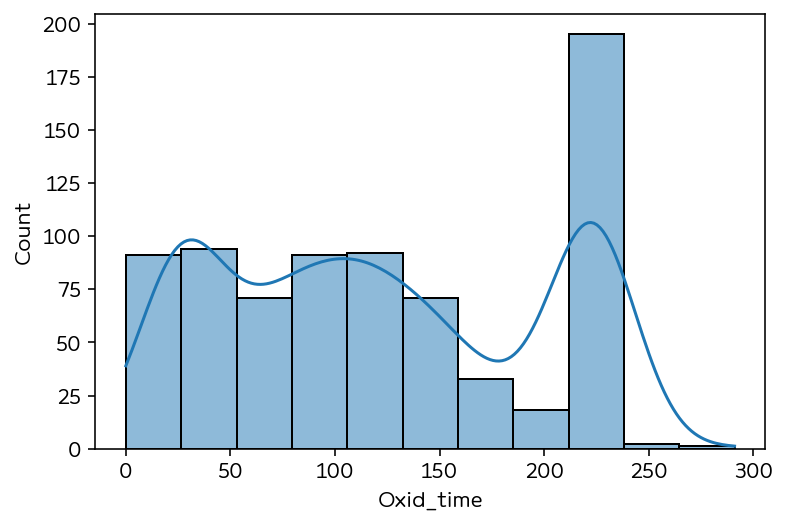

In [53]:
sns.histplot(x=df3['Oxid_time'],kde=True)

In [54]:
a= stats.normaltest(df3['Oxid_time'])
a

NormaltestResult(statistic=7551.524290228628, pvalue=0.0)

### 보강 여부에 따른 Oxidation Time의 비모수적 검정 실시(Oxidation Time이 비정규분포를 가정)

In [55]:
stats.ranksums(df3['Reinforcement'], df3['Oxid_time'])

RanksumsResult(statistic=-33.64589142300497, pvalue=3.5806148101000696e-248)

### 보강 여부에 따른 Oxidation Time의 등분산 검정 실시Oxidation Time이 비정규를 가정)

In [56]:
stats.levene(df3['Reinforcement'], df3['Oxid_time'])

LeveneResult(statistic=2173.1844060834087, pvalue=4.602723365965887e-295)

### 보강 여부에 따른 Oxidation Time의 이분산 가정 Two Sample T Test 실시

In [57]:
stats.ttest_ind(df3['Reinforcement'], df3['Oxid_time'])

Ttest_indResult(statistic=-44.90781845945852, pvalue=8.649180552050105e-281)

### UV Tpye에 따른 Out of Range의 유의미한 차이 확인

<AxesSubplot:xlabel='UV_type', ylabel='count'>

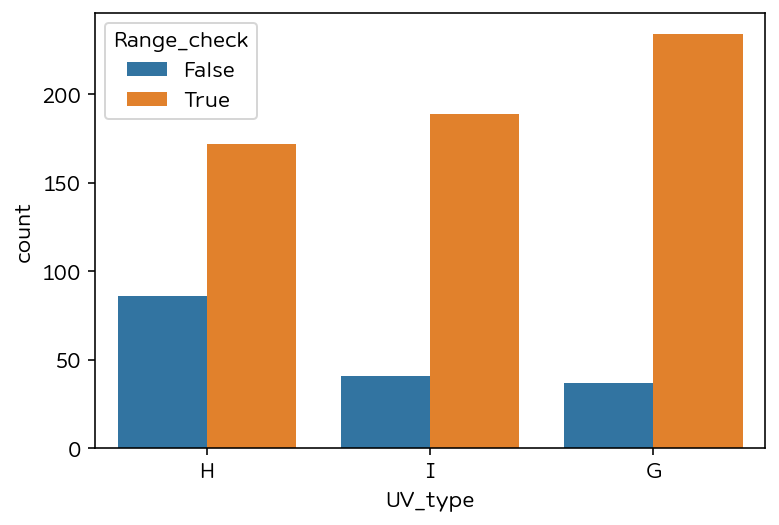

In [58]:
sns.countplot(x=df3["UV_type"], hue=df3['Range_check'])

In [59]:
df_contingency = df3.pivot_table(index='UV_type', columns='Range_check')['ER']
df_contingency

Range_check     False      True
UV_type                        
G            3.601207  3.607161
H            3.621411  3.619093
I            3.606146  3.610744

In [60]:
stats.chi2_contingency(df_contingency)

(5.45967313330836e-06,
 0.9999972701671593,
 2,
 array([[3.60281435, 3.60555382],
        [3.6188761 , 3.62162778],
        [3.60707395, 3.60981666]]))

### Etching Rate와 Target의 상관성 확인

C:\Users\Jay\anaconda3\envs\py38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


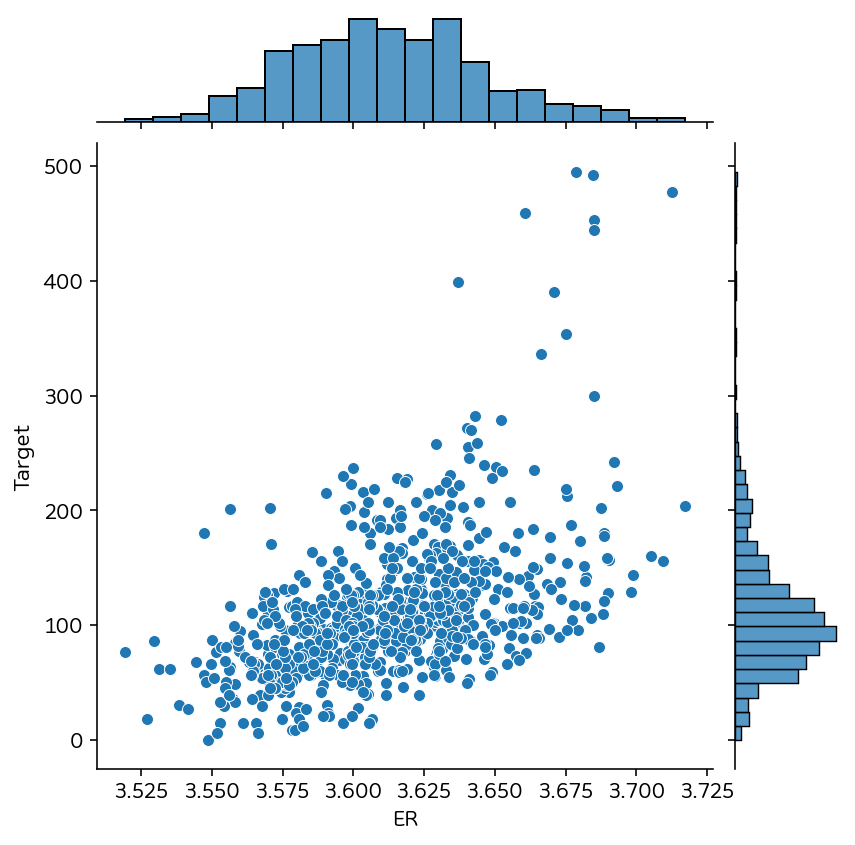

In [61]:
sns.jointplot(df3['ER'], df3['Target'])
plt.show()

### 공정 경로 별 Wafer 생산량 계산

In [62]:
a, b = df3['Chamber_Route'].value_counts().index, df3['Chamber_Route'].value_counts().values
dic = {'Chamber_Route':a, 'count':b}
Chamber_Route_count = pd.DataFrame(dic)

In [63]:
Chamber_Route_count = Chamber_Route_count.sort_values(by='Chamber_Route')
Chamber_Route_count.reset_index(drop=True, inplace=True)
Chamber_Route_count.head()

Chamber_Route  count
0   route_11111     15
1   route_11133     14
2   route_11222     25
3   route_11311     17
4   route_11333     15

In [64]:
Chamber_Route_count

Chamber_Route  count
0    route_11111     15
1    route_11133     14
2    route_11222     25
3    route_11311     17
4    route_11333     15
5    route_12111     18
6    route_12133     14
7    route_12222     20
8    route_12311     15
9    route_12333     16
10   route_13111     14
11   route_13133      9
12   route_13222     26
13   route_13311     15
14   route_13333     16
15   route_21111     14
16   route_21133     17
17   route_21222     26
18   route_21311     15
19   route_21333     16
20   route_22111     13
21   route_22133     12
22   route_22222     29
23   route_22311     12
24   route_22333     15
25   route_23111     16
26   route_23133     11
27   route_23222     34
28   route_23311     17
29   route_23333     14
30   route_31111     16
31   route_31133     15
32   route_31222     25
33   route_31311     12
34   route_31333     14
35   route_32111     15
36   route_32133     17
37   route_32222     30
38   route_32311     15
39   route_32333      8
40   route_33111     14
41   route_33133     16
42   route_33222     22
43   route_33311     16
44   route_33333     14

### 공정 경로 별 Wafer 생산량에 대한 시각화

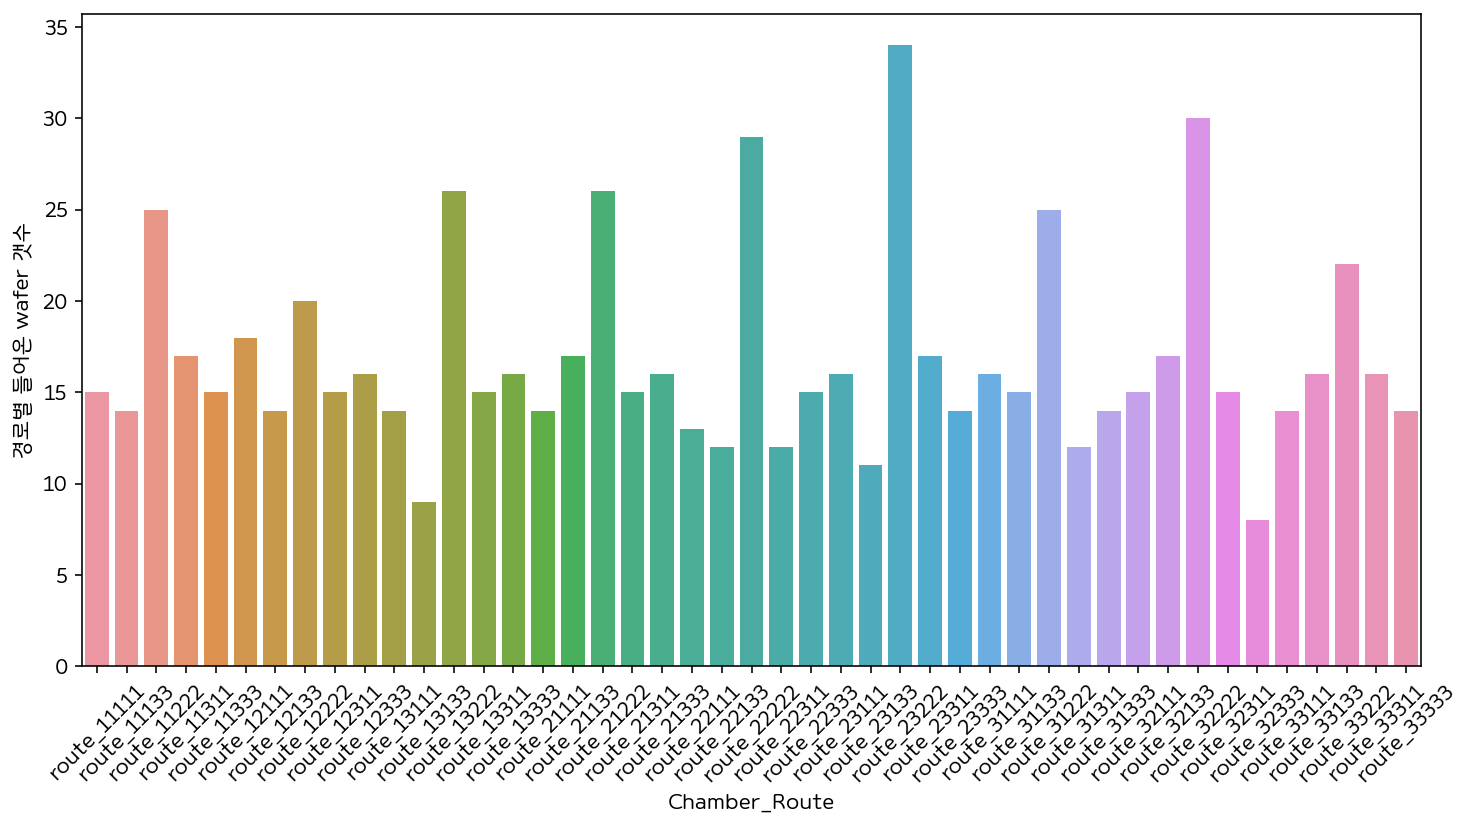

In [65]:
plt.figure(figsize=(12,6))
sns.barplot(data=Chamber_Route_count, x='Chamber_Route', y='count')
# sns.countplot(data=Chamber_Route_count, x='Chamber_Route')
plt.xticks(rotation=45)
plt.ylabel('경로별 들어온 wafer 갯수')
plt.show()

### 공정 경로 별 Wafer 내 불량 Chip 개수 계산

In [66]:
temp = df3.pivot_table(index='Chamber_Route', values='Target', aggfunc=sum)
dic = {'Chamber_Route':list(temp.index), 'Target':temp['Target']}
Chamber_Route_error = pd.DataFrame(dic)
Chamber_Route_error.reset_index(drop=True, inplace=True)
Chamber_Route_error.sort_values(by='Target', ascending=False).head(10)

Chamber_Route  Target
27   route_23222    3850
37   route_32222    3496
17   route_21222    3358
22   route_22222    3351
12   route_13222    3137
7    route_12222    2835
32   route_31222    2516
2    route_11222    2281
9    route_12333    2152
19   route_21333    2096

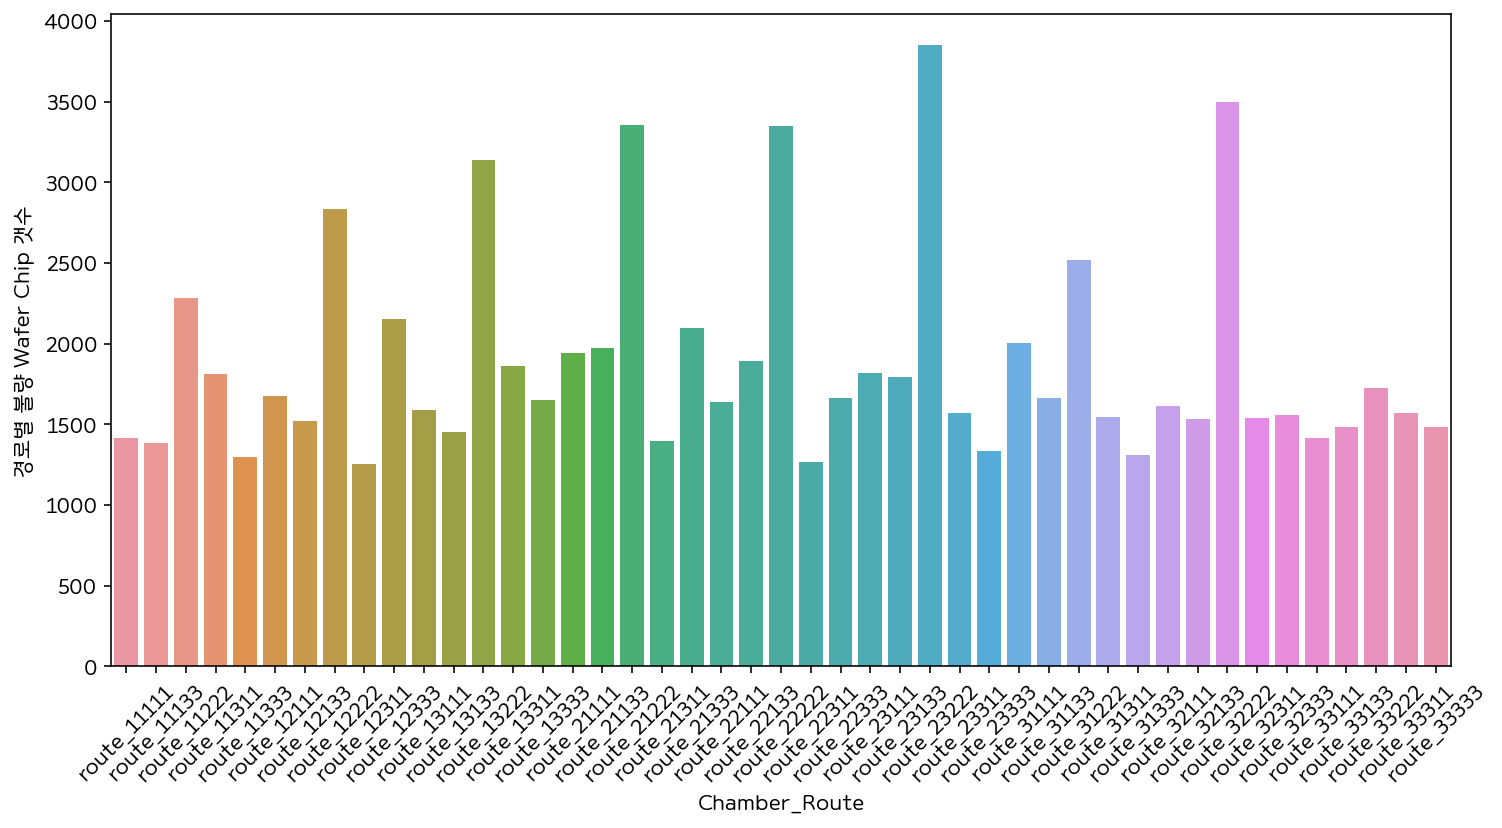

In [67]:
plt.figure(figsize=(12,6))
sns.barplot(data=Chamber_Route_error, x='Chamber_Route', y='Target')
plt.xticks(rotation=45)
plt.ylabel('경로별 불량 Wafer Chip 갯수')
plt.show()

### 공정 경로 별 Wafer 수 대비 내 불량비율(과부하) 계산

In [68]:
df3.head()

Etching_Chamber Process 3  Temp_Etching  Source_Power  Selectivity  \
0               3   Etching        70.878        50.851        1.047   
1               2   Etching        69.561        52.283        1.051   
2               1   Etching        70.968        51.610        1.017   
3               1   Etching        70.146        51.286        1.027   
4               2   Etching        71.174        51.996        1.050   

     No_Die  Thin Film 4  Thin Film 3  Thin Film 2  Thin Film 1        ER  \
0  NOLSM111        251.0       267.06       303.82       361.38  3.679333   
1  NOLSM212        317.0       332.74       369.31       426.11  3.637000   
2  NOLSM313        411.0       424.21       460.65       517.80  3.560000   
3  NOLSM414        256.0       272.28       308.56       365.93  3.664333   
4  NOLSM515        419.0       434.98       471.65       528.85  3.661667   

  Chamber_Num      process4       Flux60s       Flux90s      Flux160s  \
0           3  Implantation  9.997373e+15  1.346079e+17  3.468281e+17   
1           2  Implantation  9.705928e+15  1.389326e+17  3.838008e+17   
2           1  Implantation  1.761358e+16  8.782248e+16  6.014497e+17   
3           1  Implantation  1.148303e+16  9.776566e+16  6.646884e+16   
4           2  Implantation  9.769204e+15  1.222219e+17  2.496090e+17   

       Flux480s      Flux840s  input_Energy  Temp_implantation  Furance_Temp  \
0  3.002593e+17  6.000007e+17     31574.410            102.847         885.0   
1  3.017903e+17  6.000012e+17     31580.213            104.323         919.0   
2  2.994231e+17  6.000002e+17     32162.414            100.605         916.0   
3  2.991354e+17  6.000003e+17     32874.925            101.739         911.0   
4  3.005576e+17  6.000013e+17     30985.928            106.422         872.0   

   RTA_Temp  Target Error_message  target_binom lithography_Chamber  Line_CD  \
0       154      96          none           0.0                   1   30.959   
1       154     102          none           0.0                   2   29.653   
2       155      95          none           0.0                   3   28.063   
3       156     117          none           0.0                   1   31.556   
4       155     143          none           0.0                   2   31.969   

  UV_type  Wavelength  Resolution  Energy_Exposure  Range_check Ox_Chamber  \
0       H         405     516.657          109.769         True          1   
1       H         405     501.894          107.102         True          1   
2       I         365     506.750          110.471         True          1   
3       I         365     537.603          107.072         True          1   
4       I         365     560.574          108.073         True          1   

     process type    Temp_OXid Vapor    ppm  Pressure  Oxid_time  thickness  \
0  Oxidation  dry  1138.979159    O2  32.80     0.200       62.0    699.443   
1  Oxidation  dry  1218.184551    O2  31.86     0.194      137.0    696.792   
2  Oxidation  dry  1062.467808    O2  39.51     0.217      128.0    705.471   
3  Oxidation  dry  1114.704773    O2  32.88     0.201       90.0    710.772   
4  Oxidation  dry   989.411946    O2  38.11     0.204       98.0    716.975   

  Reinforcement photo_soft_Chamber process 2  resist_target  N2_HMDS  \
0         False                  1     Photo       1.211940   13.891   
1         False                  1     Photo       0.887720   14.722   
2          True                  1     Photo       1.113156   19.205   
3          True                  2     Photo       0.882195   16.368   
4          True                  2     Photo       0.834001   13.926   

   pressure_HMDS  temp_HMDS  temp_HMDS_bake  time_HMDS_bake    spin1  \
0         15.025     20.000         198.792          90.001  504.589   
1         15.059     19.995         198.747          89.998  492.196   
2         14.964     19.997         202.139          90.000  499.886   
3         14.944     19.998         199.

In [69]:
Chamber_Route_Table = pd.merge(Chamber_Route_count, Chamber_Route_error, on='Chamber_Route')
Chamber_Route_Table['Error_Rate'] = Chamber_Route_Table['Target'] / (200 * Chamber_Route_Table['count'])
Chamber_Route_Table.sort_values(by='Error_Rate', ascending=False).head(10)

Chamber_Route  count  Target  Error_Rate
39   route_32333      8    1561    0.975625
26   route_23133     11    1792    0.814545
11   route_13133      9    1452    0.806667
21   route_22133     12    1895    0.789583
7    route_12222     20    2835    0.708750
15   route_21111     14    1942    0.693571
9    route_12333     16    2152    0.672500
19   route_21333     16    2096    0.655000
17   route_21222     26    3358    0.645769
33   route_31311     12    1548    0.645000

### 공정 경로 별 Wafer 수 대비 내 불량비율 시각화

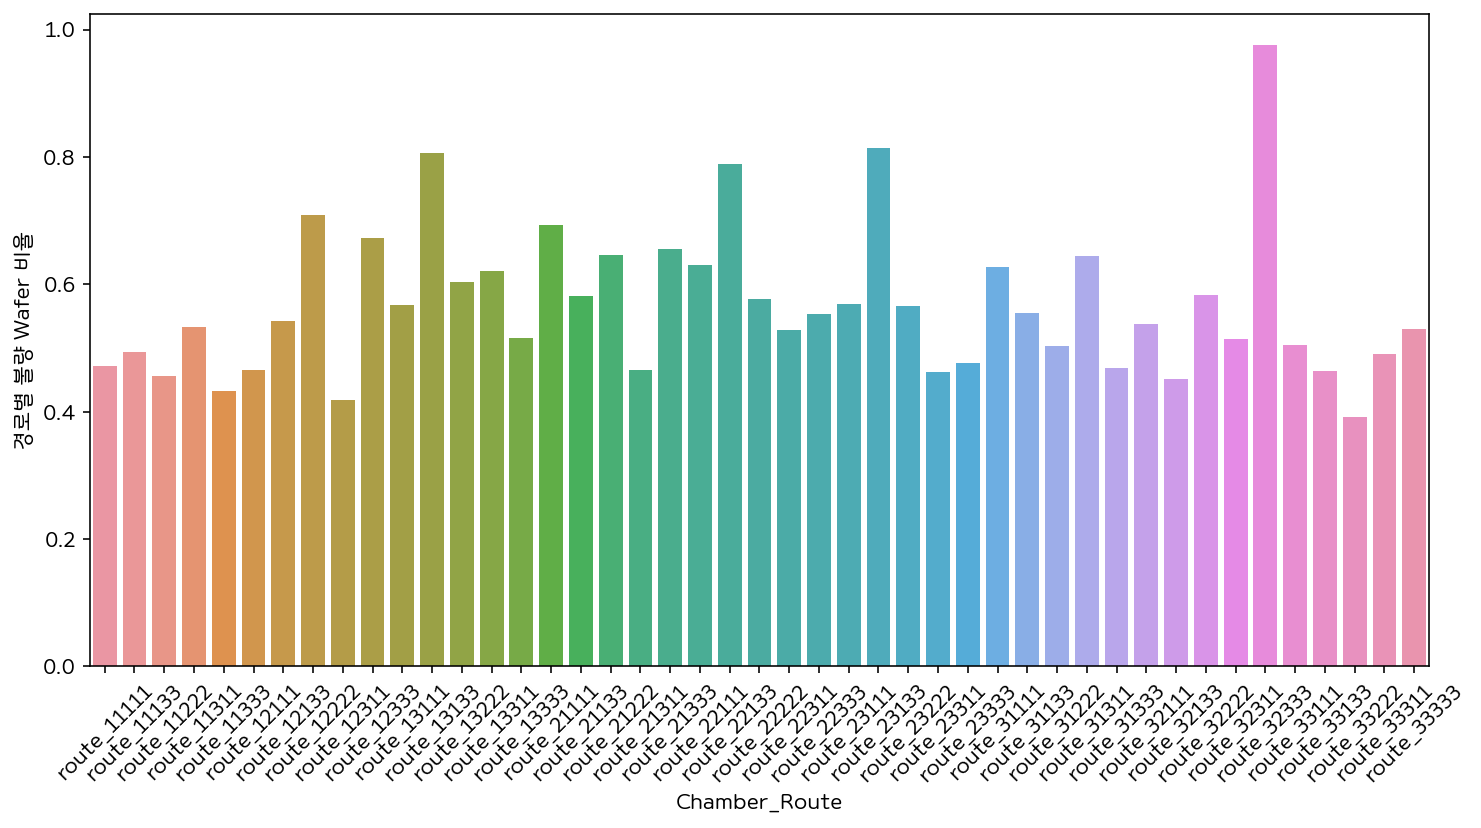

In [70]:
plt.figure(figsize=(12,6))
sns.barplot(data=Chamber_Route_Table, x='Chamber_Route', y='Error_Rate')
plt.xticks(rotation=45)
plt.ylabel('경로별 불량 Wafer 비율')
plt.show()

### 공정 경로 별 Wafer 수 대비 내 불량비율(과부하) 비율이 60%를 넘어가는 경로에 대해 과부하 여부 Column 생성

In [71]:
Chamber_Route_Table['과부하여부'] = np.where(Chamber_Route_Table['Error_Rate']>0.6, '비정상', '정상')
Chamber_Route_Table['과부하여부'].value_counts()

정상     31
비정상    14
Name: 과부하여부, dtype: int64

In [72]:
Chamber_Route_Table.head(3)

Chamber_Route  count  Target  Error_Rate 과부하여부
0   route_11111     15    1415    0.471667    정상
1   route_11133     14    1382    0.493571    정상
2   route_11222     25    2281    0.456200    정상

### 전체 모든 공정 Wafer에 대해 과부하 Route와 정상 Route를 탄 Wafer의 빈도수 시각화
- 과부하 여부 데이터를 전체 데이터와 병합
- count plot을 이용한 데이터 시각화

In [73]:
df4 = pd.merge(df3, Chamber_Route_Table, on='Chamber_Route', how='left')
print(df4.shape)
df4.head()

(759, 61)


Etching_Chamber Process 3  Temp_Etching  Source_Power  Selectivity  \
0               3   Etching        70.878        50.851        1.047   
1               2   Etching        69.561        52.283        1.051   
2               1   Etching        70.968        51.610        1.017   
3               1   Etching        70.146        51.286        1.027   
4               2   Etching        71.174        51.996        1.050   

     No_Die  Thin Film 4  Thin Film 3  Thin Film 2  Thin Film 1        ER  \
0  NOLSM111        251.0       267.06       303.82       361.38  3.679333   
1  NOLSM212        317.0       332.74       369.31       426.11  3.637000   
2  NOLSM313        411.0       424.21       460.65       517.80  3.560000   
3  NOLSM414        256.0       272.28       308.56       365.93  3.664333   
4  NOLSM515        419.0       434.98       471.65       528.85  3.661667   

  Chamber_Num      process4       Flux60s       Flux90s      Flux160s  \
0           3  Implantation  9.997373e+15  1.346079e+17  3.468281e+17   
1           2  Implantation  9.705928e+15  1.389326e+17  3.838008e+17   
2           1  Implantation  1.761358e+16  8.782248e+16  6.014497e+17   
3           1  Implantation  1.148303e+16  9.776566e+16  6.646884e+16   
4           2  Implantation  9.769204e+15  1.222219e+17  2.496090e+17   

       Flux480s      Flux840s  input_Energy  Temp_implantation  Furance_Temp  \
0  3.002593e+17  6.000007e+17     31574.410            102.847         885.0   
1  3.017903e+17  6.000012e+17     31580.213            104.323         919.0   
2  2.994231e+17  6.000002e+17     32162.414            100.605         916.0   
3  2.991354e+17  6.000003e+17     32874.925            101.739         911.0   
4  3.005576e+17  6.000013e+17     30985.928            106.422         872.0   

   RTA_Temp  Target_x Error_message  target_binom lithography_Chamber  \
0       154        96          none           0.0                   1   
1       154       102          none           0.0                   2   
2       155        95          none           0.0                   3   
3       156       117          none           0.0                   1   
4       155       143          none           0.0                   2   

   Line_CD UV_type  Wavelength  Resolution  Energy_Exposure  Range_check  \
0   30.959       H         405     516.657          109.769         True   
1   29.653       H         405     501.894          107.102         True   
2   28.063       I         365     506.750          110.471         True   
3   31.556       I         365     537.603          107.072         True   
4   31.969       I         365     560.574          108.073         True   

  Ox_Chamber    process type    Temp_OXid Vapor    ppm  Pressure  Oxid_time  \
0          1  Oxidation  dry  1138.979159    O2  32.80     0.200       62.0   
1          1  Oxidation  dry  1218.184551    O2  31.86     0.194      137.0   
2          1  Oxidation  dry  1062.467808    O2  39.51     0.217      128.0   
3          1  Oxidation  dry  1114.704773    O2  32.88     0.201       90.0   
4          1  Oxidation  dry   989.411946    O2  38.11     0.204       98.0   

   thickness Reinforcement photo_soft_Chamber process 2  resist_target  \
0    699.443         False                  1     Photo       1.211940   
1    696.792         False                  1     Photo       0.887720   
2    705.471          True                  1     Photo       1.113156   
3    710.772          True                  2     Photo       0.882195   
4    716.975          True                  2     Photo       0.834001   

   N2_HMDS  pressure_HMDS  temp_HMDS  temp_HMDS_bake  time_HMDS_bake    spin1  \
0   13.891         15.025     20.000         198.792          90.001  504.589   
1   14.722         15.059     19.995         198.747          89.998  492.196   
2   19.205         14.964     19.997         202.139          90.000  499.886   
3   16.368         14.944     19.998         1

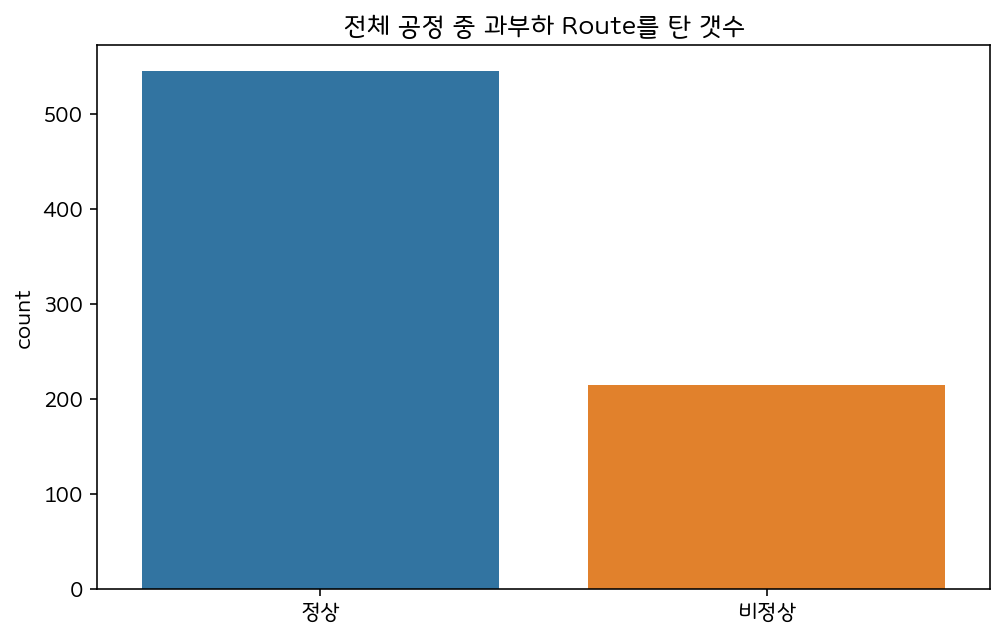

In [74]:
temp = df4['과부하여부'].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x=list(temp.index) ,y=temp.values)
plt.title('전체 공정 중 과부하 Route를 탄 갯수')
plt.ylabel('count')
plt.show()

### 공정 주요 인자들에 대한 부하여부에 따른 분포 확인

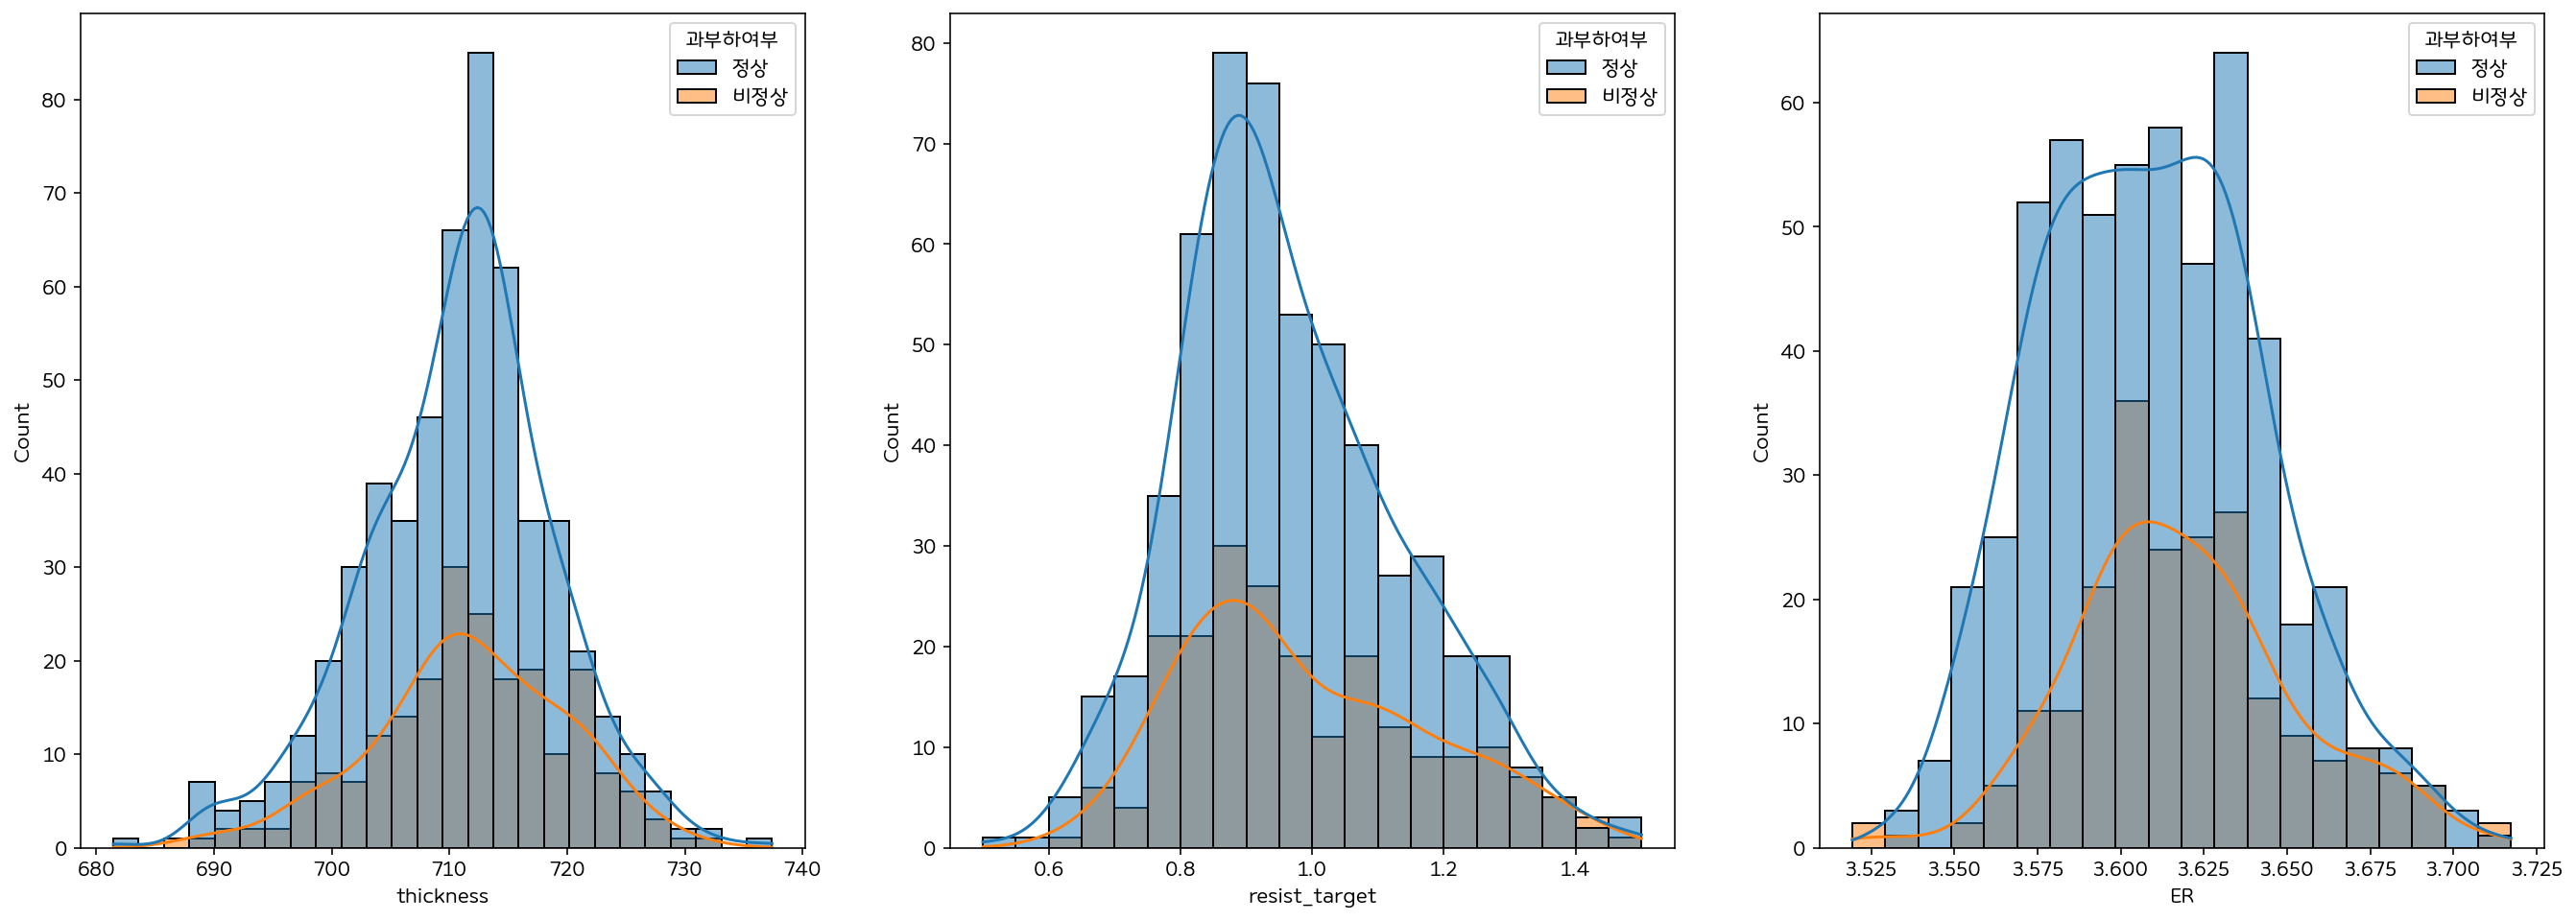

In [75]:
plt.figure(figsize=(23,8))
plt.subplot(1,3,1)
sns.histplot(x= df4['thickness'], hue=df4['과부하여부'], kde=True)
plt.subplot(1,3,2)
sns.histplot(x= df4['resist_target'], hue=df4['과부하여부'], kde=True)
plt.subplot(1,3,3)
sns.histplot(x= df4['ER'], hue=df4['과부하여부'], kde=True)
plt.show()

In [76]:
# run all cell break
a = 'strasdf123123'
print(int(a))

ValueError: invalid literal for int() with base 10: 'strasdf123123'

### 모든 공정 인자들에 대한 부하여부에 따른 분포 확인

In [77]:
df_all_numeric = df4[['ppm', 'Pressure', 'Oxid_time', 'thickness', 'resist_target', 'N2_HMDS', 'pressure_HMDS', 'temp_HMDS', 'temp_HMDS_bake',
                      'time_HMDS_bake', 'spin1', 'spin2', 'spin3', 'photoresist_bake', 'temp_softbake', 'time_softbake', 'Line_CD', 'Resolution', 
                      'Energy_Exposure', 'Temp_Etching', 'Source_Power', 'Selectivity', 'ER', 'Flux60s', 'Flux90s', 'Flux160s', 'Flux480s', 'Flux840s',
                      'input_Energy', 'Temp_implantation', 'Furance_Temp', 'RTA_Temp', 'Target_x', 'Error_Rate', '과부하여부']]

In [ ]:
# sns.pairplot(data=df_all_numeric, hue='과부하여부')

### 각 Chamber Route 별 불량 개수의 유의미한 차이가 있는지 검정

In [79]:
df4.head()

Etching_Chamber Process 3  Temp_Etching  Source_Power  Selectivity  \
0               3   Etching        70.878        50.851        1.047   
1               2   Etching        69.561        52.283        1.051   
2               1   Etching        70.968        51.610        1.017   
3               1   Etching        70.146        51.286        1.027   
4               2   Etching        71.174        51.996        1.050   

     No_Die  Thin Film 4  Thin Film 3  Thin Film 2  Thin Film 1        ER  \
0  NOLSM111        251.0       267.06       303.82       361.38  3.679333   
1  NOLSM212        317.0       332.74       369.31       426.11  3.637000   
2  NOLSM313        411.0       424.21       460.65       517.80  3.560000   
3  NOLSM414        256.0       272.28       308.56       365.93  3.664333   
4  NOLSM515        419.0       434.98       471.65       528.85  3.661667   

  Chamber_Num      process4       Flux60s       Flux90s      Flux160s  \
0           3  Implantation  9.997373e+15  1.346079e+17  3.468281e+17   
1           2  Implantation  9.705928e+15  1.389326e+17  3.838008e+17   
2           1  Implantation  1.761358e+16  8.782248e+16  6.014497e+17   
3           1  Implantation  1.148303e+16  9.776566e+16  6.646884e+16   
4           2  Implantation  9.769204e+15  1.222219e+17  2.496090e+17   

       Flux480s      Flux840s  input_Energy  Temp_implantation  Furance_Temp  \
0  3.002593e+17  6.000007e+17     31574.410            102.847         885.0   
1  3.017903e+17  6.000012e+17     31580.213            104.323         919.0   
2  2.994231e+17  6.000002e+17     32162.414            100.605         916.0   
3  2.991354e+17  6.000003e+17     32874.925            101.739         911.0   
4  3.005576e+17  6.000013e+17     30985.928            106.422         872.0   

   RTA_Temp  Target_x Error_message  target_binom lithography_Chamber  \
0       154        96          none           0.0                   1   
1       154       102          none           0.0                   2   
2       155        95          none           0.0                   3   
3       156       117          none           0.0                   1   
4       155       143          none           0.0                   2   

   Line_CD UV_type  Wavelength  Resolution  Energy_Exposure  Range_check  \
0   30.959       H         405     516.657          109.769         True   
1   29.653       H         405     501.894          107.102         True   
2   28.063       I         365     506.750          110.471         True   
3   31.556       I         365     537.603          107.072         True   
4   31.969       I         365     560.574          108.073         True   

  Ox_Chamber    process type    Temp_OXid Vapor    ppm  Pressure  Oxid_time  \
0          1  Oxidation  dry  1138.979159    O2  32.80     0.200       62.0   
1          1  Oxidation  dry  1218.184551    O2  31.86     0.194      137.0   
2          1  Oxidation  dry  1062.467808    O2  39.51     0.217      128.0   
3          1  Oxidation  dry  1114.704773    O2  32.88     0.201       90.0   
4          1  Oxidation  dry   989.411946    O2  38.11     0.204       98.0   

   thickness Reinforcement photo_soft_Chamber process 2  resist_target  \
0    699.443         False                  1     Photo       1.211940   
1    696.792         False                  1     Photo       0.887720   
2    705.471          True                  1     Photo       1.113156   
3    710.772          True                  2     Photo       0.882195   
4    716.975          True                  2     Photo       0.834001   

   N2_HMDS  pressure_HMDS  temp_HMDS  temp_HMDS_bake  time_HMDS_bake    spin1  \
0   13.891         15.025     20.000         198.792          90.001  504.589   
1   14.722         15.059     19.995         198.747          89.998  492.196   
2   19.205         14.964     19.997         202.139          90.000  499.886   
3   16.368         14.944     19.998         1

In [92]:
temp = df4[['Chamber_Route', 'Target_y', 'count']]
temp = temp.pivot_table(index='Chamber_Route', values=['Target_y', 'count'])
temp['Normal_Die'] = (temp['count']*2000) - temp['Target_y']
temp.rename(columns={'Target_y':'Target_die'}, inplace=True)
temp.drop(columns='count')
temp = temp[['Normal_Die', 'Target_die']]
temp.head()
# Normal_Die 28585
# Target_Die 1415

Normal_Die  Target_die
Chamber_Route                        
route_11111         28585        1415
route_11133         26618        1382
route_11222         47719        2281
route_11311         32189        1811
route_11333         28703        1297

In [ ]:
# df4.columns

# 6. Modeling

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

In [ ]:
# Y = df1['target_binom']
# X = df1.drop(columns=['Ox_Chamber', 'process', 'type', 'Vapor', 'No_Die', 'Reinforcement', 'photo_soft_Chamber',
#                                'process 2', 'lithography_Chamber', 'UV_type', 'Range_check', 'Etching_Chamber', 'Process 3',
#                                'Chamber_Num', 'process4', 'Error_message', 'target_binom', 'Target', 'Datetime_x', 'Datetime_y', 'Lamp', 'Wafer_map'])

In [ ]:
Y = df4['target_binom']
a = list(df4.columns)
b = ['Ox_Chamber', 'process', 'type', 'Vapor', 'No_Die', 'Reinforcement', 'photo_soft_Chamber',
                               'process 2', 'lithography_Chamber', 'UV_type', 'Range_check', 'Etching_Chamber', 'Process 3',
                               'Chamber_Num', 'process4', 'Error_message', 'target_binom', '과부하여부', 'Chamber_Route']
X = df4.drop(columns=b)
X.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=0)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
# X_train

In [ ]:
from tqdm import tqdm

In [ ]:
clf_grid = GridSearchCV(DecisionTreeClassifier(), n_jobs=-1,
            param_grid={'class_weight': [None, 'balanced'],
                            'criterion':['gini', 'entropy'],
                            'max_depth': [2,3,4,5,6,7],
                            'min_samples_leaf': [3,4,5,6,7],
                            'min_samples_split': [4,5,6,7,8]},
            scoring='f1')
clf_grid.fit(X_train, y_train)
print(clf_grid.score(X_train, y_train))
print('Best Parameter : ', clf_grid.best_params_)
print('Best Estimators : ', clf_grid.best_estimator_)
# clf_grid = GridSearchCV(RandomForestClassifier(random_state=0), param_grid=params, n_jobs=-1)
# clf_grid.fit(train1, label1)
# print(clf_grid.score(train1, label1))
# # best hyperparameter를 찾아준다.
# print('Best Parameter : ', clf_grid.best_params_)
# print('Best Estimators : ', clf_grid.best_estimator_)

In [ ]:
a=1